# Regresión lineal: predecir los gastos médicos de pacientes
---

Para este ejercicio utilizaremos los datos presentados en [este](https://www.kaggle.com/mirichoi0218/insurance) dataset de Kaggle en el cual se presentan datos de seguros médicos. 


## Descarga e instalación de librerías

Lo primero que se hará es descargar la librería **[regressors](https://pypi.org/project/regressors/)** que ayudará a hacer un análisis más profundo sobre la regresión lineal.

In [1]:
!pip install regressors

In [2]:
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid', context='notebook')

## Descargando los datos
Descarguemos los datos y veamos cómo se ven.

In [3]:
df = pd.read_csv('insurance.csv')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'insurance.csv'

## Analizando los datos
Se observará cómo se distribuyen los datos de la variable a predecir.

(1338, 7)


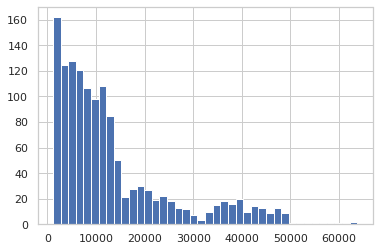

In [ ]:
print(df.shape)
df.charges.hist(bins = 40)

Algo que analizar, según este gráfico, es entender qué está pasando con los datos arriba de los 50,000. Parece haber muy pocos datos de este lado.

In [ ]:
df[df.charges>50000]
df = df[df.charges<50000]

En este caso, al ser pocos datos (6 de 1338), eliminaremos estos datos atípicos. A modo didáctico producen más ruido en la predicción que se está intentando hacer en este ejercicio. 

Sin embargo es importante aclarar que **NO SE DEBEN ELIMINAR** datos atípicos sin antes conocer a alguien que conozca o sea experto en los datos para que pueda guiarnos mejor sobre ellos.

## Viendo correlaciones
Ahora entendamos nuestros datos viendo cómo se distribuyen y correlacionan. 

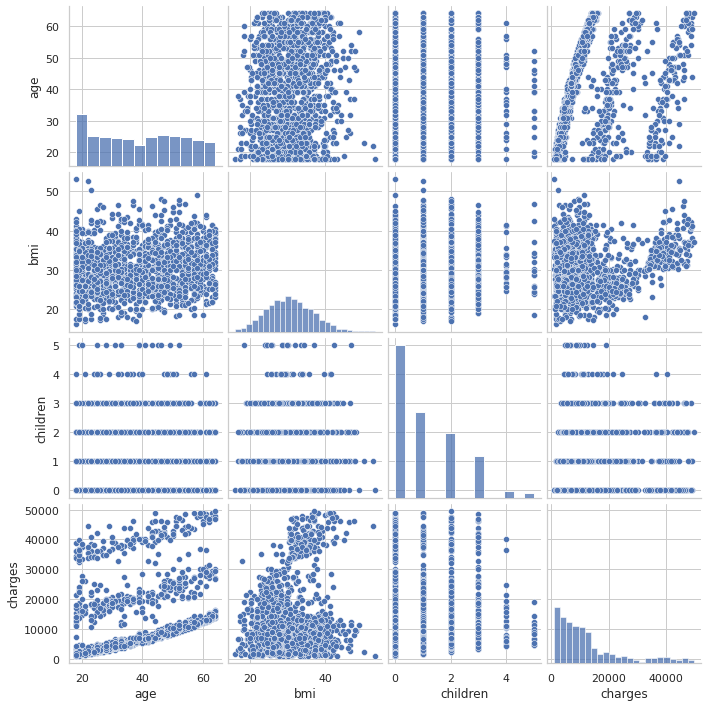

In [ ]:
import matplotlib.pyplot as plt
sns.pairplot(df, height=2.5)
plt.show()

Puntos interesantes a ver:

- Hay 3 grupos de personas diferentes que se clasifican en edad / cargos, esto puede ser un punto a analizar después.

En general los valores se distribuyen de manera esperada. Con valores extremos en el caso de los cargos, sin embargo esto es de esperarse pues los cargos en los hospitales pueden variar mucho por quedarse un día más en el hospital o incluso por procedimientos extras.

- Parece que los datos están limpios, la variable de índice de masa corporal se distribuye de manera normal o gausiana, lo cual sería esperado en un índice de este tipo.

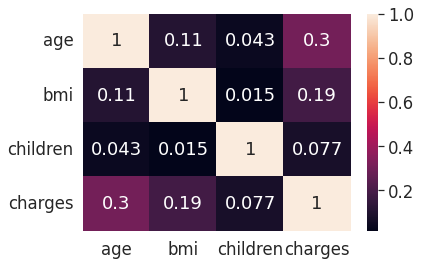

In [ ]:
import numpy as np
numeric_cols = ['age', 'bmi', 'children', 'charges']
cm = np.corrcoef(df[numeric_cols].values.T)
sns.set(font_scale=1.5)
sns.heatmap(cm,annot=True, yticklabels=numeric_cols,xticklabels=numeric_cols)

## Utilizando las demás variables
Las demás variables son variables categoricas, sexo, fumador, región. Para poder utilizarlas utilizaremos la función **[get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)** de pandas. 

Ahora la verás en acción

In [ ]:
df = pd.get_dummies(df, columns=['sex','smoker','region'], drop_first=True)
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


## Creando modelos 
Primero se usará un modelo con todas las variables.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
X_cols = list(set(df.columns)-set(['charges']))
y_col = ['charges']

X = df[X_cols].values
y = df[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X,y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [ ]:
y_pred.shape

(333, 1)

## Funciones de métricas
El siguiente punto es calcular las métricas del modelo.

In [ ]:
import sklearn.metrics as metrics
mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("r2 ", r2.round(4))
print("mse: ", mse.round(4))

r2  0.7697
mse:  0.2591


El siguiente código muestra un resumen general de los resultados.

In [ ]:
from regressors import stats
model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)

In [ ]:
y_test = y_test.reshape(-1)

print("==========Summary==========")
stats.summary(model, X_test, y_test, X_cols)

==========Summary==========
Residuals:
    Min      1Q  Median      3Q     Max
-1.8489 -0.1222  0.0791  0.2163  0.9345


Coefficients:
                  Estimate  Std. Error  t value   p value
_intercept       -0.005553    0.028088  -0.1977  0.843408
region_southwest -0.032156    0.031010  -1.0370  0.300510
region_northwest -0.022494    0.033639  -0.6687  0.504154
children          0.047785    0.027654   1.7280  0.084925
smoker_yes        0.794573    0.026867  29.5745  0.000000
region_southeast -0.031243    0.033605  -0.9297  0.353194
age               0.300694    0.028067  10.7133  0.000000
bmi               0.156064    0.029228   5.3396  0.000000
sex_male         -0.015819    0.028036  -0.5643  0.572957
---
R-squared:  0.76970,    Adjusted R-squared:  0.76402
F-statistic: 135.36 on 8 features


Finalmente tenemos la función que calcula los residuales. Es importante notar que es una simple resta entre los valores reales y los predichos.

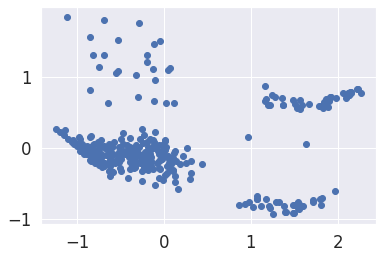

In [ ]:
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.show()


## Segundo modelo
Estos resultados de arriba son buenos, pero se pueden mejorar. Intentaremos hacer algunas transformaciones sobre las variables que pueden ser de utilidad.

In [ ]:
df_second = df.copy()
df_second['age2'] = df_second.age**2
df_second['sobrepeso'] = (df_second.bmi >= 30).astype(int)
df_second['sobrepeso*fumador'] = df_second.sobrepeso * df_second.smoker_yes

Analizando el segundo modelo

In [ ]:
X_cols = ['sobrepeso*fumador', 'smoker_yes', 'age2', 'children']
y_col = ['charges']

X = df_second[X_cols].values
y = df_second[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X,y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression(fit_intercept=False)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [ ]:
mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("r2 ", r2.round(4))
print("mse: ", mse.round(4))

r2  0.8768
mse:  0.1277


In [ ]:
model.coef_ = model.coef_.reshape(-1)

In [ ]:
y_test = y_test.reshape(-1)

print("==========Summary==========")
stats.summary(model, X_test, y_test, X_cols)

==========Summary==========
Residuals:
    Min      1Q  Median      3Q     Max
-1.9279  0.0743  0.1123  0.1307  0.3754


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept         0.000000    0.019603   0.0000  1.000000
sobrepeso*fumador  0.494777    0.025694  19.2568  0.000000
smoker_yes         0.463099    0.026688  17.3524  0.000000
age2               0.321788    0.019338  16.6399  0.000000
children           0.066119    0.019792   3.3407  0.000931
---
R-squared:  0.87679,    Adjusted R-squared:  0.87529
F-statistic: 583.54 on 4 features


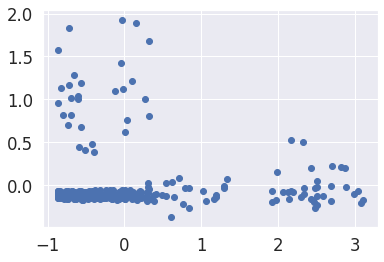

In [ ]:
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.show()
